# Titanic Community Solution

To understand how I can improve my data science/machine learning skills in the context of Kaggle competitions, I will review a select competition solution and investigate how others approach the problem. Because there are many solutions, I will choose one that I feel is explained well and is a thorough improvement to my own.

For the Titanic solution, I have chosen to replicate "Titanic Top 4% with ensemble modeling" by Yassine Ghouzam, PhD. Linked [here](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling).

## Approach

Dr. Ghouzam approaches the problem as follows

* Feature Analysis
* Feature Engineering
* Modeling

## Imports

In [1]:
# To ignore warinings from sklearn covergence etc
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

### Load Data/Preview Data

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
IDtest = test["PassengerId"]

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Outlier Detection

Outliers can have dramatic effect on model training and prediction (especially for regression).

Tukey method (Tukey JW., 1977) for outlier detection defines an outlier as outside the IQR plus an outlier step. In this case, we can define outlier as those with a numerical feature value outside (IQR +- outlier step).

Outlier rows are defined as rows with at least two outlier numerical values. Numerical features for our data are Age, SibSp, Sarch and Fare.

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
# see outlier rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


So we have 10 outlier rows to drop. Mostly it looks like high values of SibSP (all from same family). IMO, it doesn't make sense to drop these unless we know SibSP has an effect on the model, but we can follow the good Dr's advice and check SibSP later.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Join Train and Test Set

Join datasets to get same number of features during categorical conversion (during feature engineering). 

It seems like this is also relevant for imputing missing numerical values down the line. Also, some feature anaylsis is done with this combined datset (only some??).

As it turns out, we do feature analysis related to the chance of survival with the train dataset because we need the labels.

In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Check for Null/Missing Values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan) # np.nan must be better than native NaN

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features are missing a significant portion of values.

Survived is only missing values in test dataset (this is our target).

In [8]:
# Summarize Data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical Values

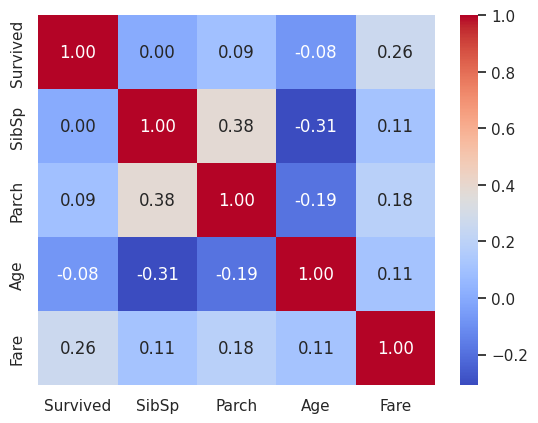

In [9]:
# Correlation matrix for numerical features and survived

g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Fare seems to have the only significant correlation with survived. 

This doesn't mean other features aren't useful. We could have subpopulations in these features that correlate with survival so we need to do a more in depth analysis per feature to determine this.

### SibSP

Draw a categorical plot (formerly factorplot) of the sibsp values. Although SibSP is numerical, we can "bin" the values here (there are only 5 unique values for SibSP) and consider it to be categorical.

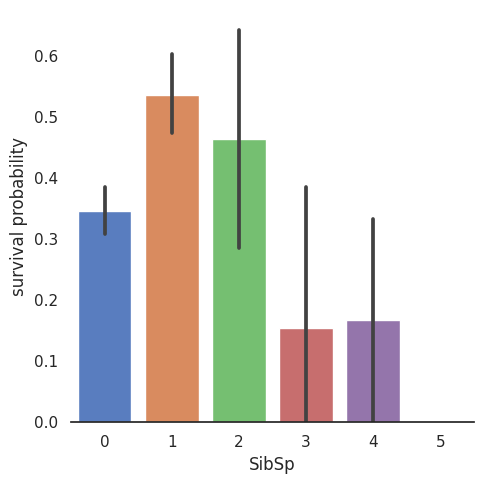

In [10]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems like more siblings/spouses means less chance of survival.

Interesting obeservation, and it might be worth making a new feature to describe these categories in feature engineering.

### Parch

Do the same as above for the Parch feature.

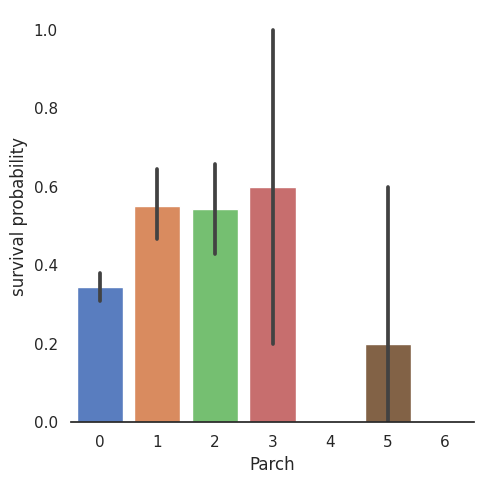

In [11]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems small families have more chance to survive than large families.

There is an important standard deviation in the survival of passengers with 3 parents/children.

For the two categorical plots above it seems to me like the standard deviation of the higher value groups is too large to consider. But, I will continue with the Dr's analysis.

### Age

Create an anylsis of age feature across survived/died groups.

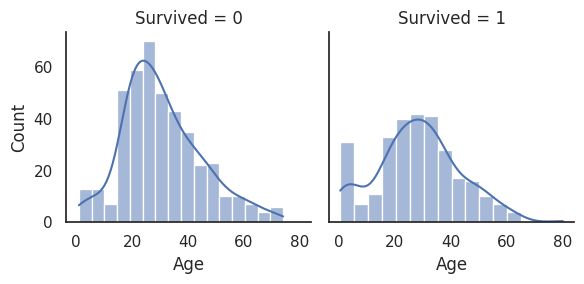

In [12]:
# Explore Age vs Survived

# facetgrid maps datasets onto multiple axes for graphing
# in this case, we create two axes. Survived=0 and Survived=1
g = sns.FacetGrid(train, col='Survived')
# create histogram for both groups
# Dr uses distplot but this is deprecated
g = g.map(sns.histplot, "Age", kde=True)

Age seems to have tailed or Gaussian (normal) distribution.

There is definitely a difference between the two histograms. Notably, the peak in young survivors and less old survivors.

Thus, although we did not see a correlation with age and survived, we can see passengers of a certain age are more or less likely to survive.

It seems young passengers have more chance to survive, we can see this in more detail with the overlayed kdeplot below.

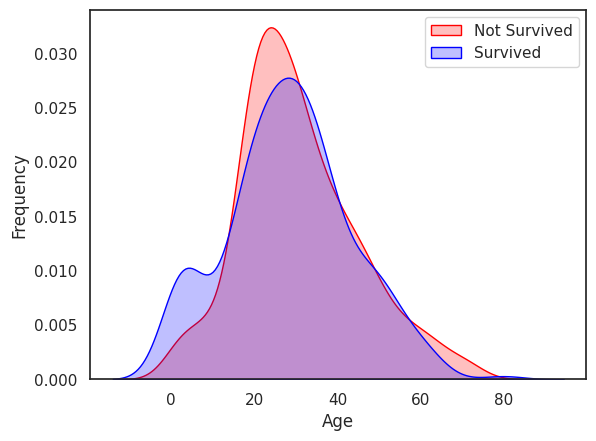

In [13]:
# Explore Age distibution 

# create density plot of age for different survival groups
# this is analogous to histogram and represents data with continous probability density curve
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", fill= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Now we can clearly see the differnece younger survivors and old diers.

I am going to add one more plot here. The chance of surviving as a determined by age. I think it will be interesting to see the odds for each age group.

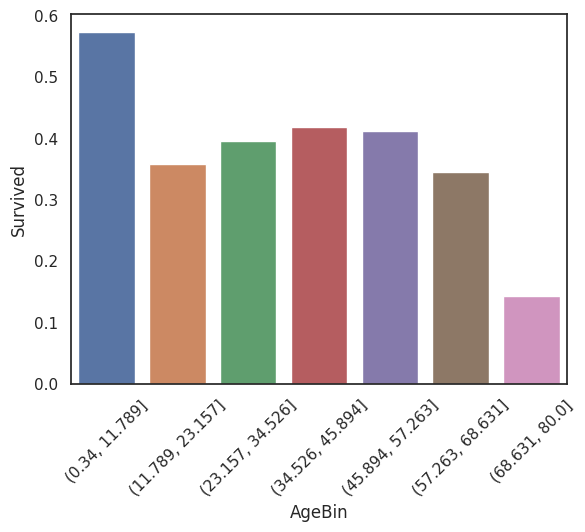

In [14]:
# Bin the age data
train['AgeBin'] = pd.cut(train['Age'], bins=7)

# Calculate the survival rate for each bin
age_group = train.groupby('AgeBin')['Survived'].mean().reset_index()

# Plotting
plt.xticks(rotation=45)
g = sns.barplot(data=age_group, x='AgeBin', y='Survived')

train = train.drop("AgeBin", axis=1)

Hmmm. It definitely looks like the younger are more likely to live and the older are more likely to die.

However, it seems like the choice of the number of bins will signficantly impact our results here and thus this might not be the best type of analysis.

### Fare

We know from before fare has one missing value. We can simply fill this with the median fare value and this will not have an important effect on prediction.

Let's also look at the fare distribution to understand how the data is spread out.

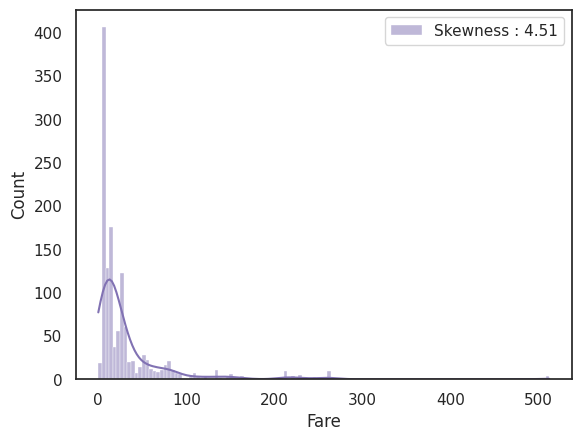

In [15]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

# Explore Fare distribution 
g = sns.histplot(dataset["Fare"], kde=True, color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Skewness values within -1/-0.5 and 0.5/1 indicate slight skewing. But a value of 4.51 is very highly skewed. 

This can lead to overweight high values in model, even with feature scaling. This, it is better to transform this data with log function to reduce the skew.

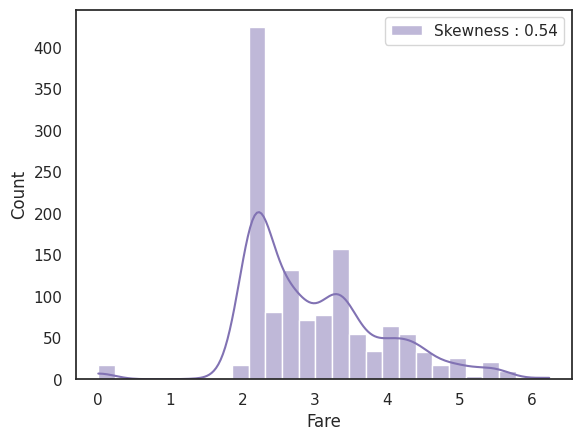

In [16]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i+1))


# Explore new Fare distribution 
g = sns.histplot(dataset["Fare"], kde=True, color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Much less skewed! Log transformation is helpful for reducing skew!

## Categorical Features

### Sex

We can use a barplot to see a person's chance of surviving based on their gender alone.

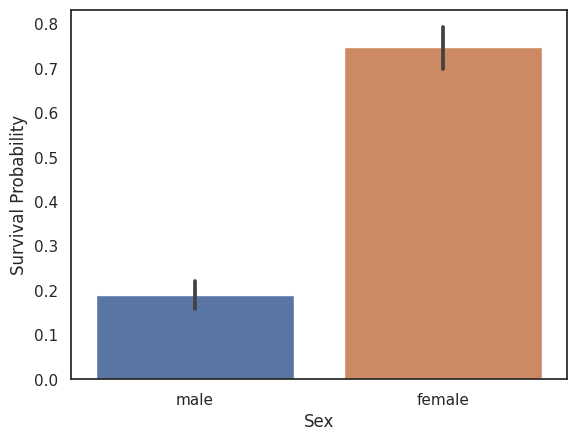

In [17]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

Clearly, male have less chance of surviving than femail.

Thus, sex likely plays an important role in survival.

### Pclass

We can make a similar bar plot to see survival by Pclass.

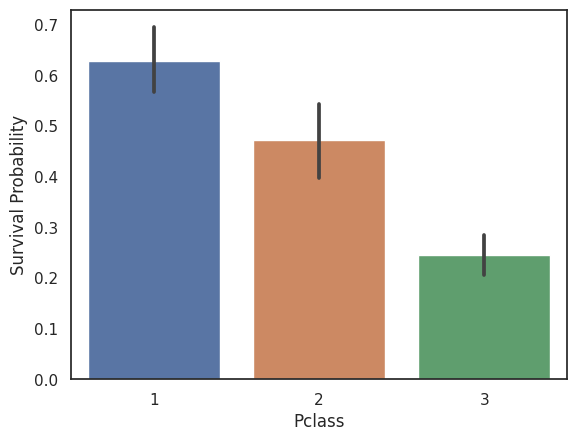

In [18]:
g = sns.barplot(x="Pclass",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

It looks like this feature has some impact on survival. Let's see if we can get a better idea of how sex and pclass both affect survival with a categorical plot.

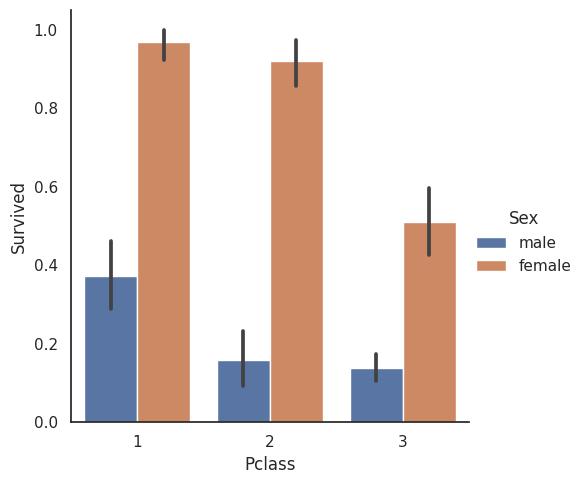

In [19]:
g = sns.catplot(data=train, x="Pclass", y="Survived", hue="Sex", kind="bar")

Okay so higher class passengers are more likely to survive, and we see this trend conserved by gender.

### Embarked

First, we need to fill in the missing values. We know from before there are 2 missing values. We can impute with the most common value like below.

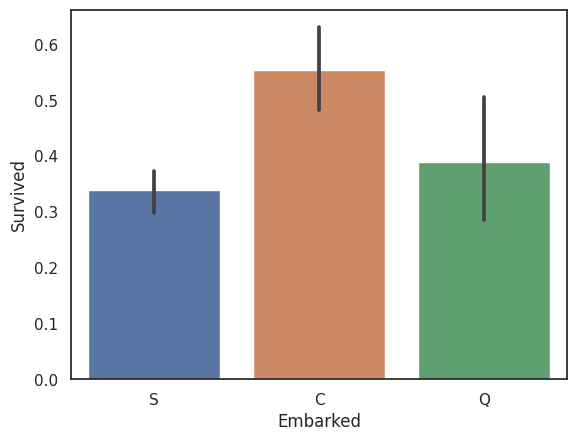

In [20]:
# fill with most common value, aka "Mode"
dataset["Embarked"] = dataset["Embarked"].fillna(train["Embarked"].mode())

g = sns.barplot(data=train, x="Embarked", y="Survived")

It seems like a passenger coming from C (Cherbourg) has a greater chance of surviving. But why? They got on the ship at a different place but fell into the water in the same place...

Well, we hypothesize that the people from Cherbourg have the bag and are in a higher SEC. Let's see how embarked compares to fare.

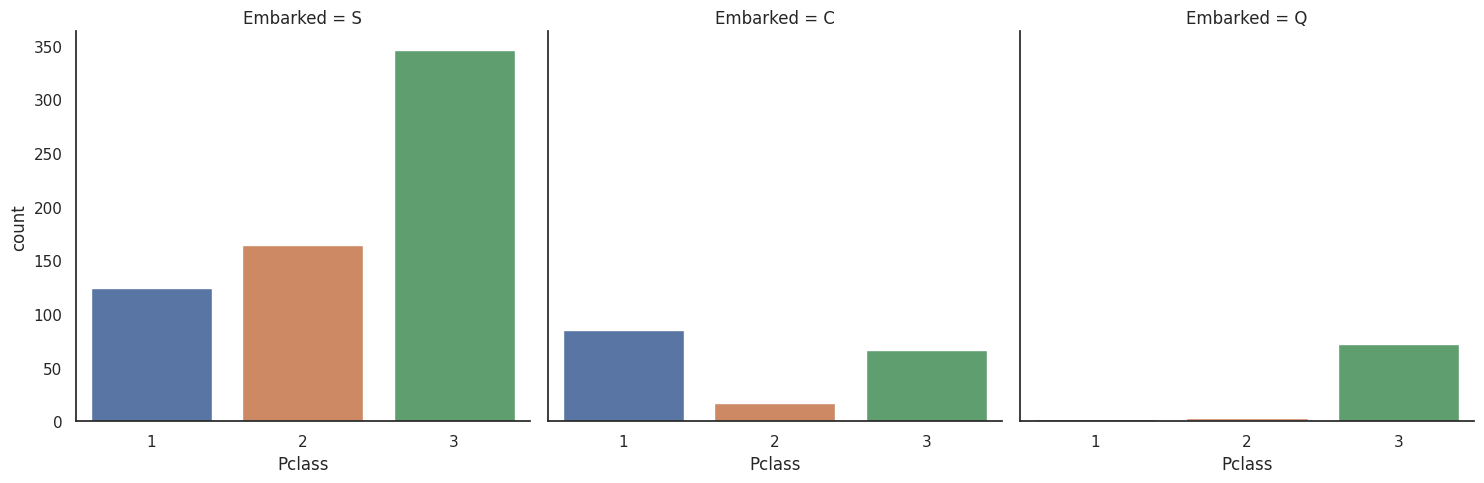

In [21]:
# make a categorical plot that gets the counts of different pclass across different embarked
g = sns.catplot(x="Pclass", col="Embarked", data=train, kind="count")

Okay so the poorer people make up a much larger portion of the people from S and Q. So if richer people were to be prioritized during evacuation, C would benefit the most proportional to the other groups, which we observe here.

## Filling Missing Values

### Age

Age has 256 missing values for entire dataset.

Since we have seen that subpopulations of age have different chances of surviving (children vs elderly), it would be nice to keep age feature and impute missing values.

Let's look at the features possibly correlated with age (Sex, Parch, Pclass, and SibSP) to see how we can best impute this value.

We can use boxplots to analyze the spread of age across the other features listed above. It is unclear why the good Dr chooses to use Pclass as a hue for sex and only for this feature. We shall continue with the analysis as per usual.

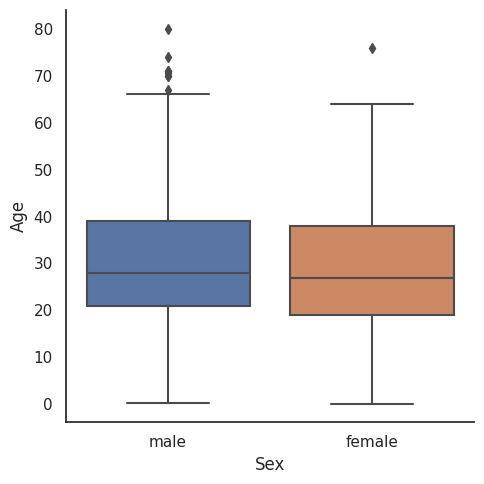

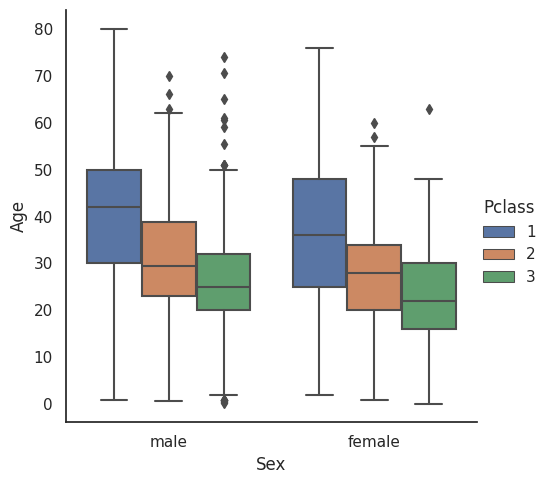

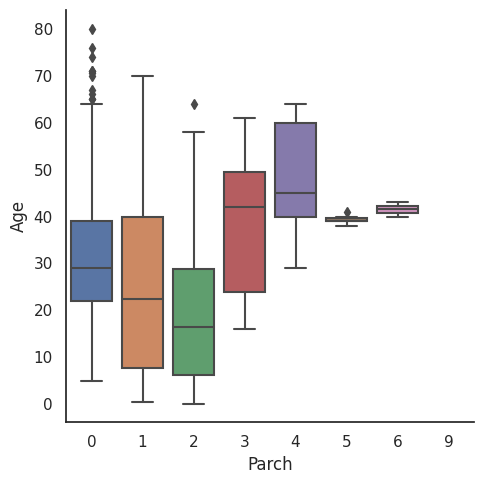

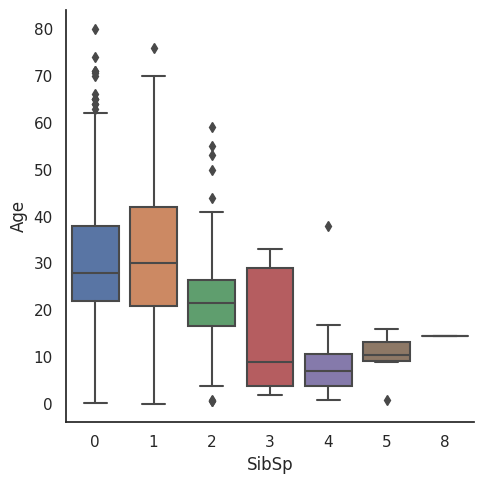

In [22]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

Age distribution is about the same in male and female subpopulations, so sex doesn't seem to help predict age.

However, we see various links for the other features to age.

Let's see if there are correlations between the features and age!

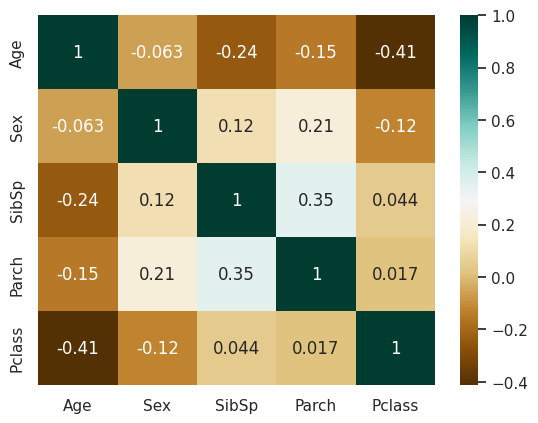

In [23]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

# note that in the boxplots above we could observe correlations so we can do this
# if we noticed that, for example, Pclass went in a curve with boxplots, this would not be helpful
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True)

This confirms what we saw in boxplots for feature correlations except Parch.

Here, Mr. Dr says:

> In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

>So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.

>The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp

But, it makes sense that if there are 2 parents or children, the subject is most likely a child with 2 parents. Of course, after that it is more likely an older person that has multiple children.

Anyways, we proceed to predict age value from Pclass, Parch and SibSp. We calculate the median age of passengers who have the same 'SibSp', 'Parch', and 'Pclass' values as the current row with missing age. If this value exists, use it, else use median age of entire dataset.

In [24]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    # Calculate median age of the entire dataset
    age_med = dataset["Age"].median()
    
    # Define a mask for passengers with the same SibSp, Parch, and Pclass
    mask = ((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & 
            (dataset['Parch'] == dataset.iloc[i]['Parch']) & 
            (dataset['Pclass'] == dataset.iloc[i]['Pclass']))
    
    # Calculate the median age of passengers with the same SibSp, Parch, and Pclass
    age_pred = dataset["Age"][mask].median()

    # Impute the Age
    if not np.isnan(age_pred):
        dataset.loc[i, 'Age'] = age_pred
    else:
        dataset.loc[i, 'Age'] = age_med

Now we should see how age looks for the survived and dead groups.

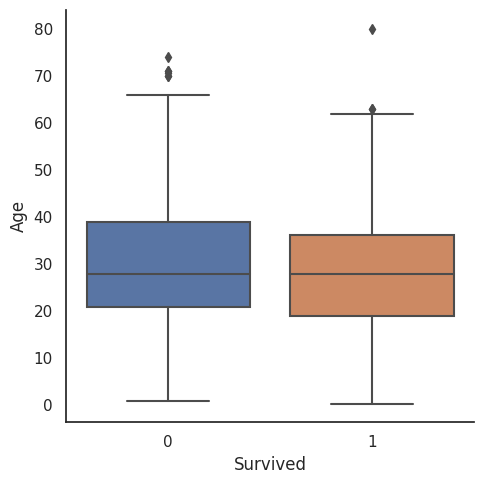

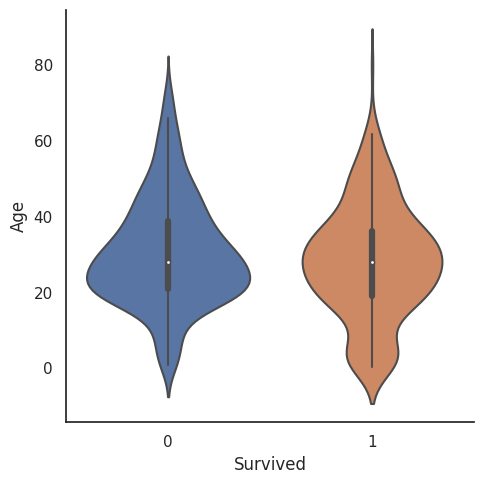

In [25]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

Here we see no difference in media age of survived and dead groups, but clearly the younger groups have a better survival rate. Note the hump in the violin plot for younger groups.

Interestingly, the doctor does not check the same distributions that we created for age earlier, but I will do that myself.

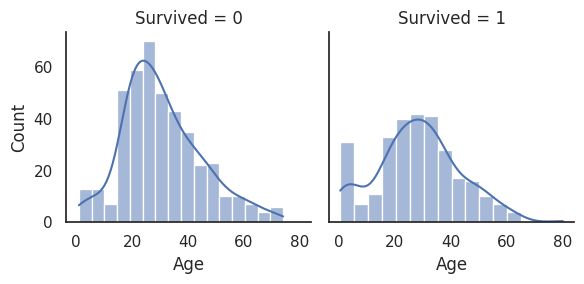

In [26]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age", kde=True)

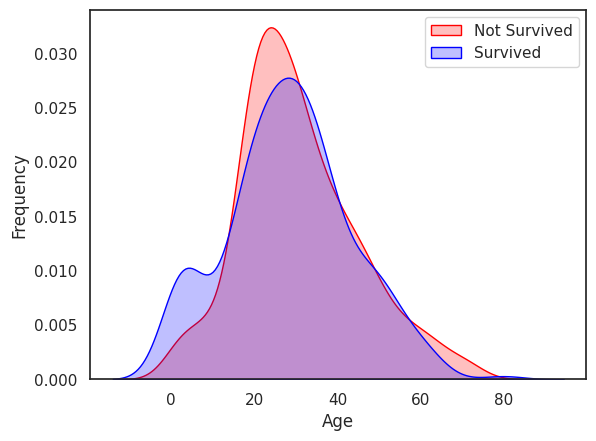

In [27]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0)], color="Red", fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1)], ax =g, color="Blue", fill= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Cool! I'm not sure if we would have been able to see a difference in these distributions after filling in 256 values, but we dont.

## Feature Engineering

### Name

Let's try to get some information from the name feature. This is a complex string so let's preview it and determine the best way to get information relevant to survival.

In [28]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

While we could maybe derive information like race that might have an effect on survival, we can start with a feature related to SEC and gender - title. 

We can get the title as the word between the , and the .

In [29]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)

# see titles of passengers
dataset["Title"].value_counts()

Title
Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

Many titles are very rare, we can group them into a rare group. We can also group the titles for females because there are not many of them.

In [30]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
# for some reason Dr maps to integers here
# Seems a bit strange since we have other categorical string values like embarked
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

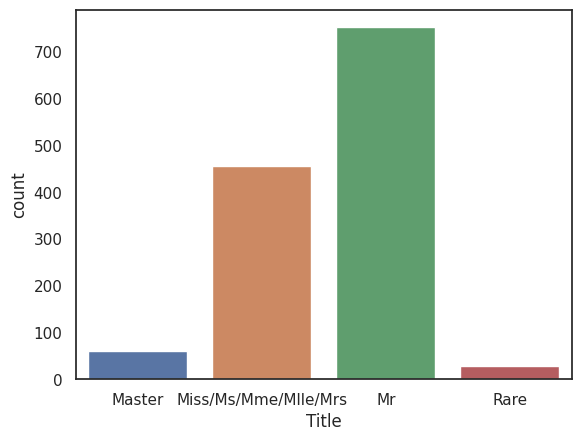

In [31]:
g = sns.countplot(x="Title", data=dataset)
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

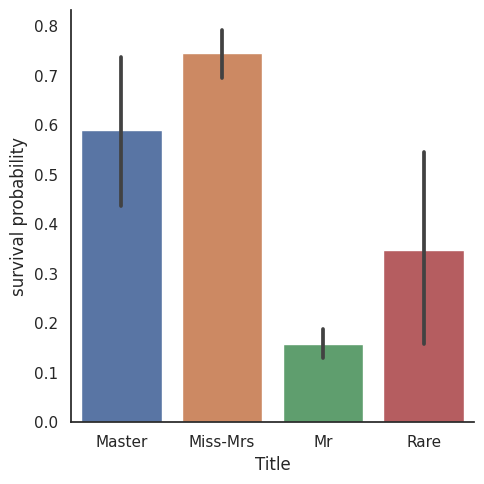

In [32]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

We already know that females are more likely to survive than males, but interestingly we see that master and rare titles are more likely to survive too.

Now we can drop the name feature and just use our new feature, title!

In [33]:
dataset = dataset.drop("Name", axis=1)

### Family Size

We hypothesize that large families have difficulties evacuating as they look for each other during the evacuation. 

Let's create a "Fsize" feature for family size that is the sum of SibSp, Parch, and 1 (the passenger).

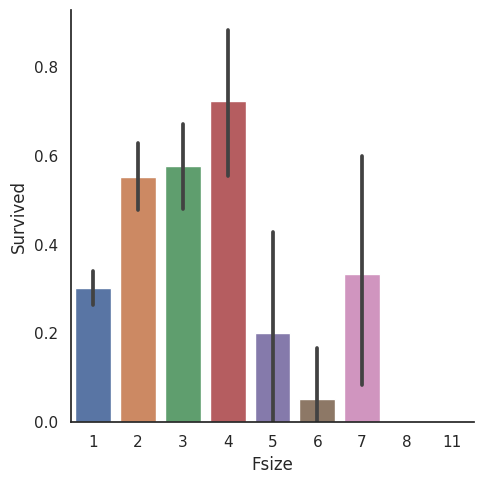

In [34]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

# see survival probability by Fize
# Dr uses line plot?? Im using bar plot instead
g = sns.catplot(data = dataset, x="Fsize", y="Survived", kind="bar")

The Dr concludes

> The family size seems to play an important role, survival probability is worst for large families.

I'm not so sure about this conclusion, but family size does seem to play a role. Let's create 4 categories of family size.

The Dr uses 4 separate binary features... hmm. I think I would normally just do one string feature (like embarked) but I will continue with this approach.

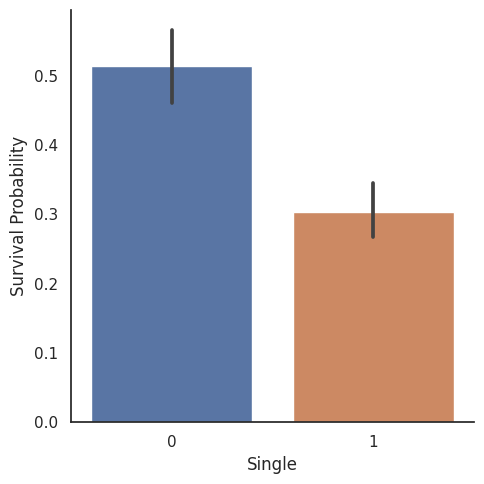

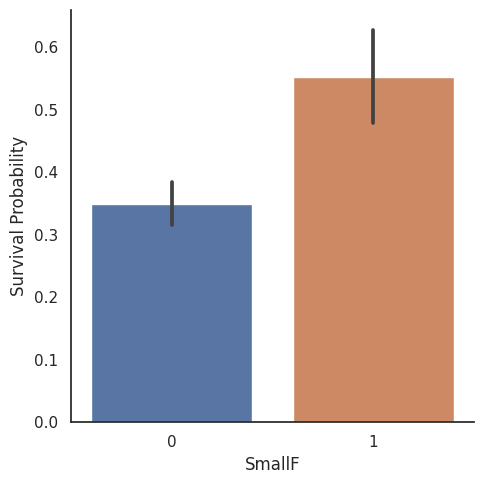

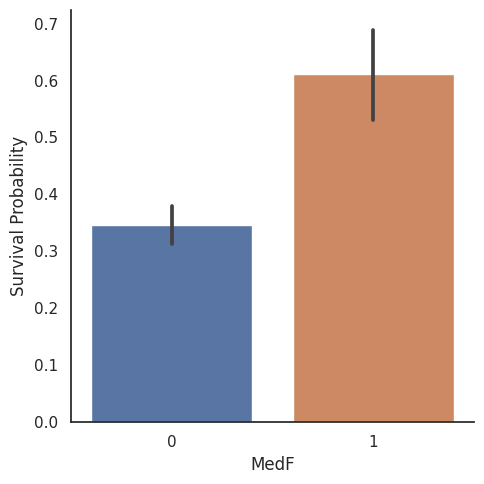

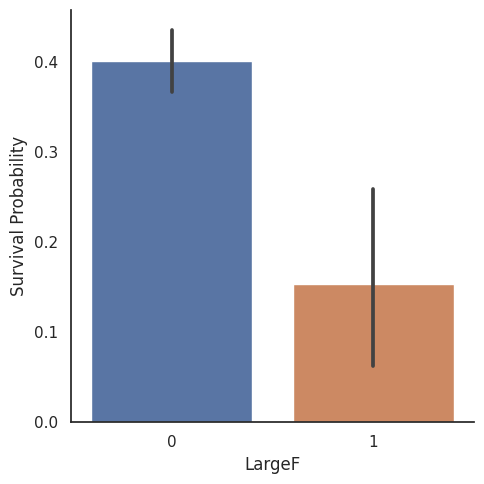

In [35]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

# see survival for each of these groups
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

This seems to be a good grouping. Each group seems to have a better chance of suriving or dying.

Okay as it turns out we should be using "indicator" or "dummy" variables for our categorical features. This means that we present each observation as a 0 or 1 and apparently helps the models.

So, let's get the indicator values for our other categorical features - title and embarked.

In [36]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,2.110213,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.280593,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.188856,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.990834,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.202765,NaN,...,0,0,0,False,False,True,False,False,False,True


### Cabin

First, let's see what the cabin data looks like.

In [37]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [38]:
dataset["Cabin"].isnull().sum()

1007

So, the Cabin feature has 292 values and 1007 missing values.

In order to create a categorical variable for Cabin that preserves information, we can use the first letter of the Cabin, which preserves information about the probable location of the passenger.

In order to not loose all of the information from this column, we can give the passengers without a cabin value a made up value. Let's use X.

In [39]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

dataset["Cabin"].value_counts()

Cabin
X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

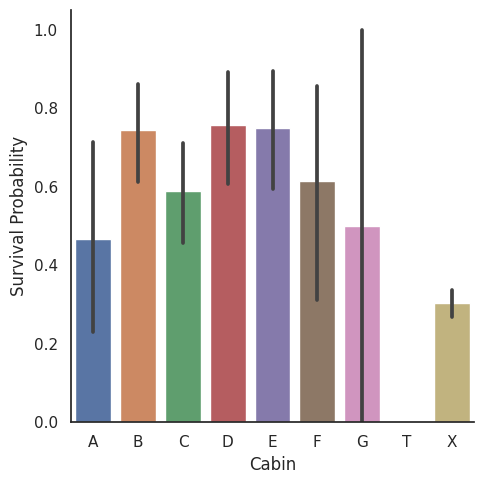

In [40]:
# see survival for these different cabin groups
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

While the standard deviations of these survival rates are quite large, we can see that the groups do seem to have an effect on survival.

Let's get indicator values for this feature.

In [41]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")

### Ticket

Let's see what this feature looks like.

In [42]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [43]:
dataset["Ticket"].isnull().sum()

0

How do we use this feature?

It is likely the tickets with similar prefixes are in some group. Let's use the prefix instead of the entire ticket.

If no ticket prefix, we make up prefix X.

In [44]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket

dataset["Ticket"].value_counts()

Ticket
X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
C            8
SOC          8
SOPP         7
STONO2       7
SCParis      5
SCAH         5
PP           4
LINE         4
WEP          4
FC           3
SOTONO2      3
SCA4         2
SWPP         2
PPP          2
SC           2
SCA3         1
A            1
LP           1
AQ4          1
STONOQ       1
Fa           1
CASOTON      1
AS           1
SCOW         1
SOP          1
SP           1
AQ3          1
Name: count, dtype: int64

IMO, this is probably not a super useful feature given the crazy number of categories. But, I will proceed with the good Dr's approach.

In [45]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

### Pclass

We already looked at Pclass and it seems like a useful feature as is. Let's get indicator values.

In [46]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [47]:
# Drop class labels
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [48]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,2.110213,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.280593,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.188856,1,1,0,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.990834,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.202765,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True


# Modeling

Finally! Onto modeling...

First, let's get the training and testing data ready.

In [49]:
train = dataset[:train_len]
test = dataset[train_len:]

test = test.drop(labels=["Survived"], axis=1)

In [50]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

## Different Features, Same Models

Before we proceed with the Dr's models, I want to try my same approach with various sklearn classification models on the feature-engineered datasets. 

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

def sklearn_model_pipeline(numerical_features: list, categorical_features: list, sklearn_model: object) -> Pipeline:
    # define preprocessors
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    # define transformers with imputation and preprocessing methods
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    
    # define preprocessor for all data
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical_transformer", numerical_transformer, numerical_features),
            ("categorical_transformer", categorical_transformer, categorical_features),
        ]
    )

    # create model pipeline
    model_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", sklearn_model),
        ]
    )
    return model_pipeline

In [52]:
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

# create data and target subsets of training data
data_train, target_train = (
    train.drop(columns="Survived"),
    train["Survived"],
)

numerical_features = data_train.columns.tolist()
categorical_features = []

# list of models we want to test classification accuracy for
models_list = [
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    SVC()
]

for model in models_list:
    model_pipeline = sklearn_model_pipeline(numerical_features, categorical_features, model)
    cv_results = cross_validate(model_pipeline, data_train, target_train, cv=10) # for the size of our datset, 10 folds seems reasonable
    scores = cv_results["test_score"]
    print(f"Model: {model}, Accuracy: {scores.mean()}")

Model: LogisticRegression(), Accuracy: 0.8183861082737488
Model: RandomForestClassifier(), Accuracy: 0.8138661899897854
Model: GradientBoostingClassifier(), Accuracy: 0.8274642492339123
Model: HistGradientBoostingClassifier(), Accuracy: 0.8218335035750766
Model: SVC(), Accuracy: 0.8183861082737488


Okay so after all of that work feature engineering it seems we get <1% accuracy increase for these models.

But, maybe these simple models can't capture the information in the features we have engineered.

Time to proceed with the Dr's approach.

## Simple Modeling

Let's see how 10 popular models perform with stratified kfold cross validation. We can measure performance with mean accuracy.

These models are:
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [53]:
# create stratified folds for cross validation
kfold = StratifiedKFold(n_splits=10)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Text(0.5, 1.0, 'Cross validation scores')

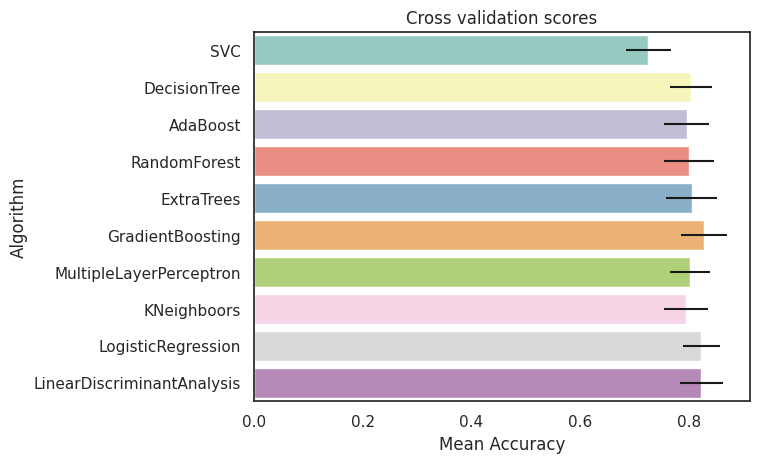

In [54]:
# model with different algorithms

# random state for sklearn operation
random_state = 2

# define classifiers to use
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    # Dr does not explain defining learning rate here
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state, max_iter=500),
    KNeighborsClassifier(),
    LogisticRegression(random_state = random_state, max_iter=500),
    LinearDiscriminantAnalysis()
]

# derive performance statistics for all models
cv_results = []
for classifier in classifiers:
    result = cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=4)
    cv_results.append(result)
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h", xerr=cv_std)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")

My models performed different (but comparably) to the Dr's. The only exception was SVC. For me, it was the worst by far but for him it was the best (by a little).

Anyways, we use SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

### Hyperparameter Tuning

Now we can try to optimize the Adaboost, ExtraTrees, RandomForest, GradientBoosting, and SVC classifiers with grid search optimization.

In [55]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"estimator__criterion" : ["gini", "entropy"],
              "estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

# best score
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8252808988764044

In [56]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793668

In [57]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342951991828397

In [58]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["log_loss"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8320097037793668

In [59]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### Learning Curves

We should analyze the learning curves of the model to make sure they are not overfitting to the training data. Let's define a function to do this and apply it to the models we have trained.

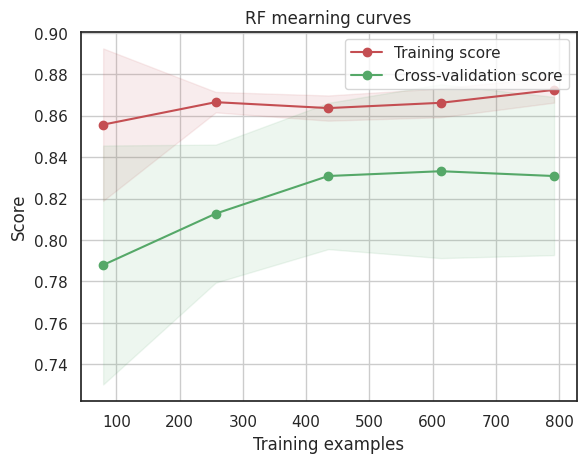

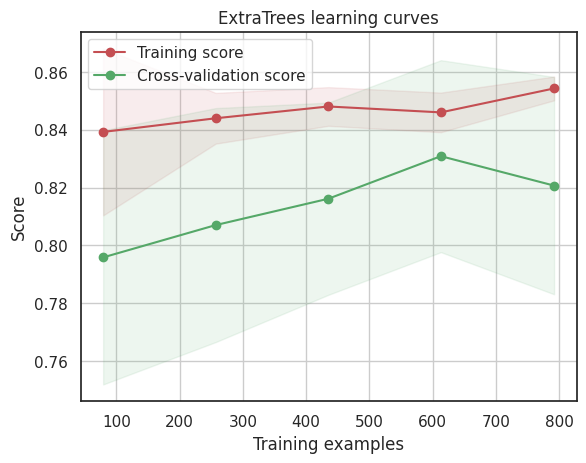

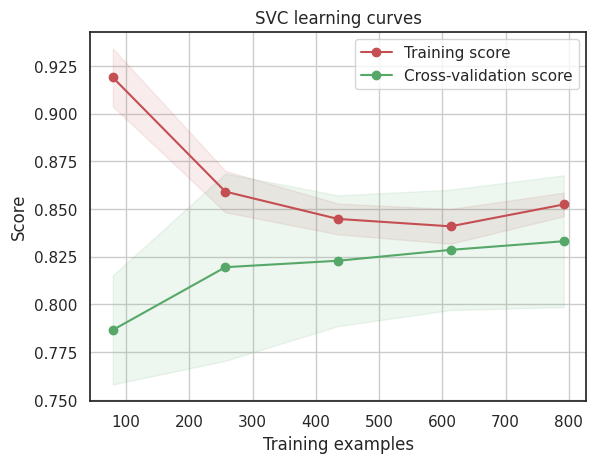

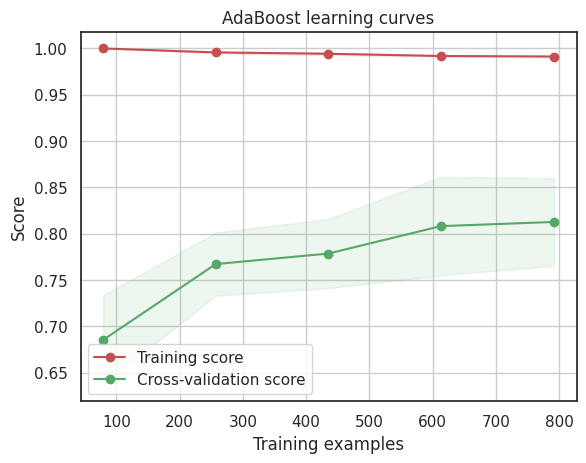

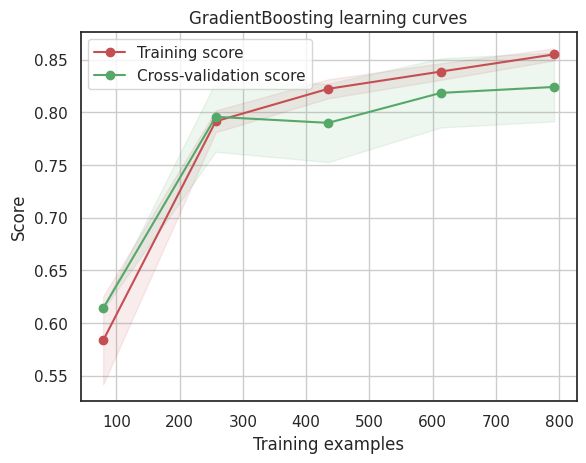

In [60]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 5)):
    """Generate simple plot of test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

So it looks like Adaboost and GradientBoosting overfit the training set (training score outside range of cross-val score).

SVC and ExtraTrees classifiers are better at generalizing their predictions (training and cross-val curves are close).

### Feature importance of tree-based classifiers

Let's see what the most informative features are for the prediction of passenger survival. We can display feature importance for the 4 tree based classifiers.

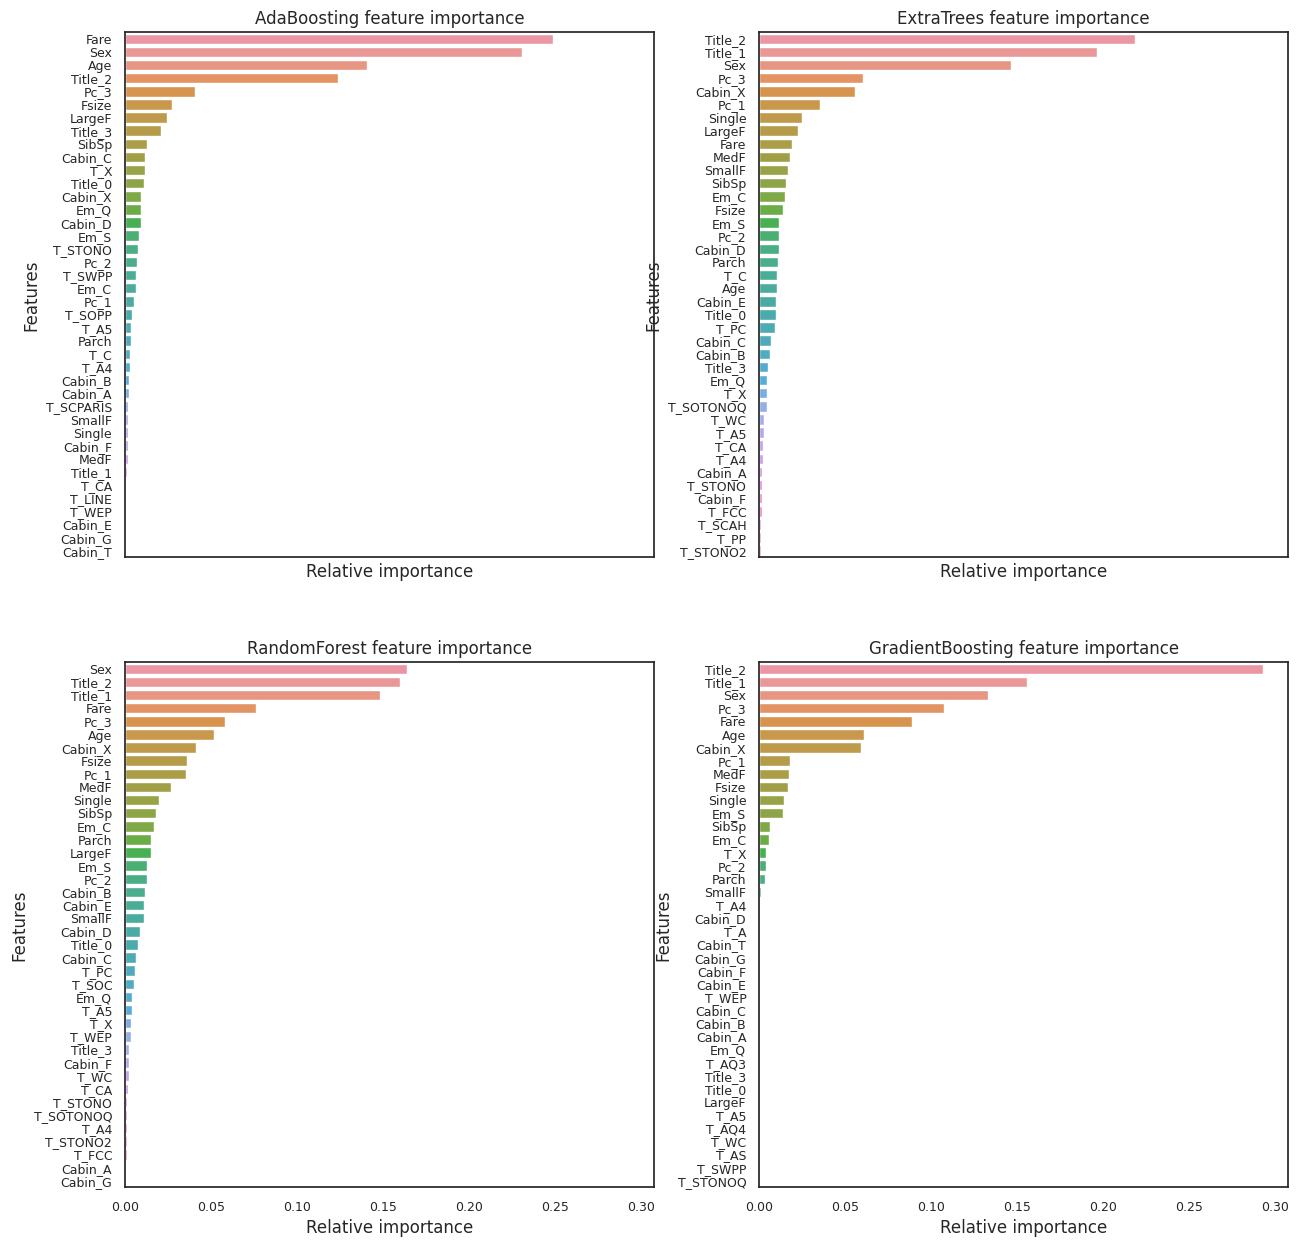

In [61]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", figsize=(15,15))

names_classifiers = [
    ("AdaBoosting", ada_best), 
    ("ExtraTrees", ExtC_best), 
    ("RandomForest", RFC_best), 
    ("GradientBoosting", GBC_best)
]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        # get top 40 most important features, as det by model
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

Okay so it looks like the 4 classifiers have different top features according to relative importance. Thus, these models use different methods to make their predictions. But, they definitely place similar importance on some features. Feare, Title_2, Age, and Sex always rank highly.

Our conclusions of the highly ranking features:
* Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.
* Sex, Title_2 (Mrs,Miss,Ms, etc group), and Title_3(Mr) refer to the gender.
* Age and Title_1(Master, way of referring to boys) relate to age of passenger.
* Fsize, LargeF, MedF, Single refer to the size of the passenger family.

Thus, the prediction of survival seems to be more associated with Age, Sex, family size, and social standing than the location in the boat.

Let's comapre the classifier test predictions against each other.

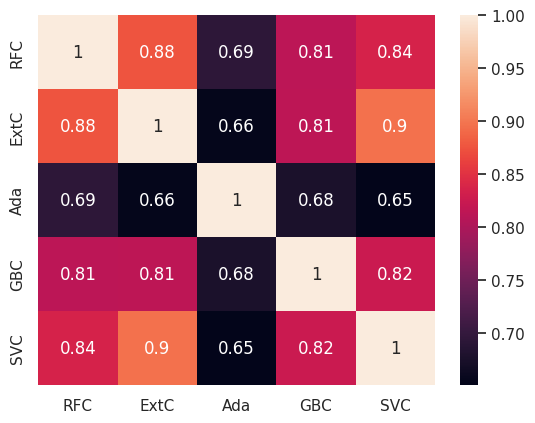

In [62]:
# create series for model test predictions
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# concatenate predictions into dataframe
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

# see correlation of predictions
g = sns.heatmap(ensemble_results.corr(),annot=True)

It looks like most classifiers make similar predictions, with the exception of Adaboost.

The differences between the 5 classifier predictions are enough to consider an ensembling vote.

## Ensemble Modeling

### Combining Models

Let's use a voting classifier to combine the predictions for each model. However, we want to take into account the probability of each vote. We can do this with the "soft" voting parameter.

Interestingly, even though we know adaboost and gradientboost classifiers tend to overfit, the Dr. still wants to use both of them here, fit with all of the training data.

In [63]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting="soft", n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## Predict Results

Finally, we get to predict results of the test data and see how the models do!

In [64]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)